In [1]:
# Scientific libraries
import numpy_html
import numpy as np
import scipy.stats as stats
import scipy.special as sf
import scipy.integrate as integrate
import scipy.interpolate as interpolate

# import Pandas

import pandas as pd
import astropy.io.fits as fits
import astropy.units as u
import astropy.constants as const

# Graphic libraries

import matplotlib.pyplot as plt
%matplotlib notebook
from jupyterthemes import jtplot
plt.style.use('mike_dark') 
jtplot.style(context='notebook', fscale=1, grid=False)

from glob import glob
import copy
import collections
#import warnings
#warnings.simplefilter('ignore')

import stan_utility

green = "#1DEBA6"
red = "#FF0059"
yellow = "#F6EF5B"


from pyipn import copy_template, Universe

In [2]:
#copy_template()

<IPython.core.display.Javascript object>


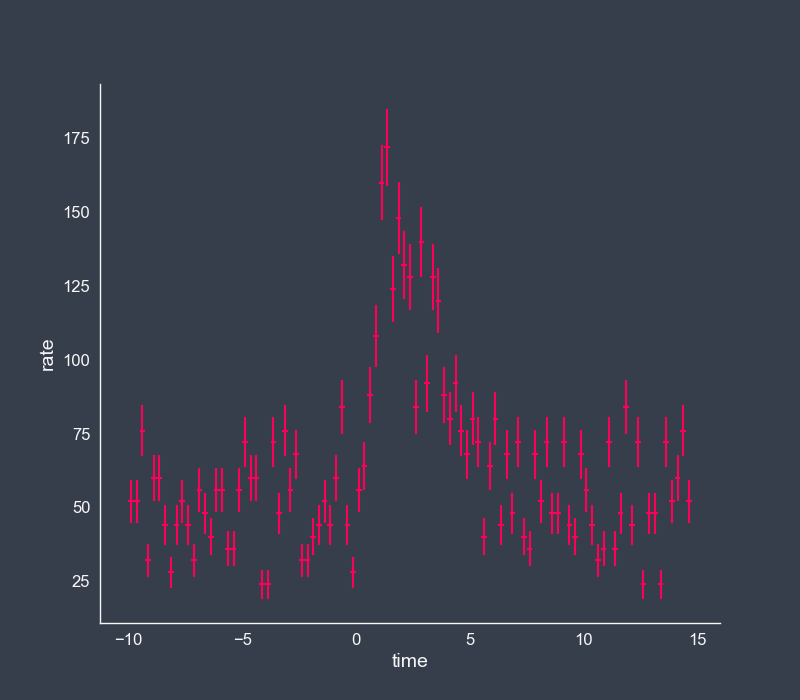

<IPython.core.display.Javascript object>


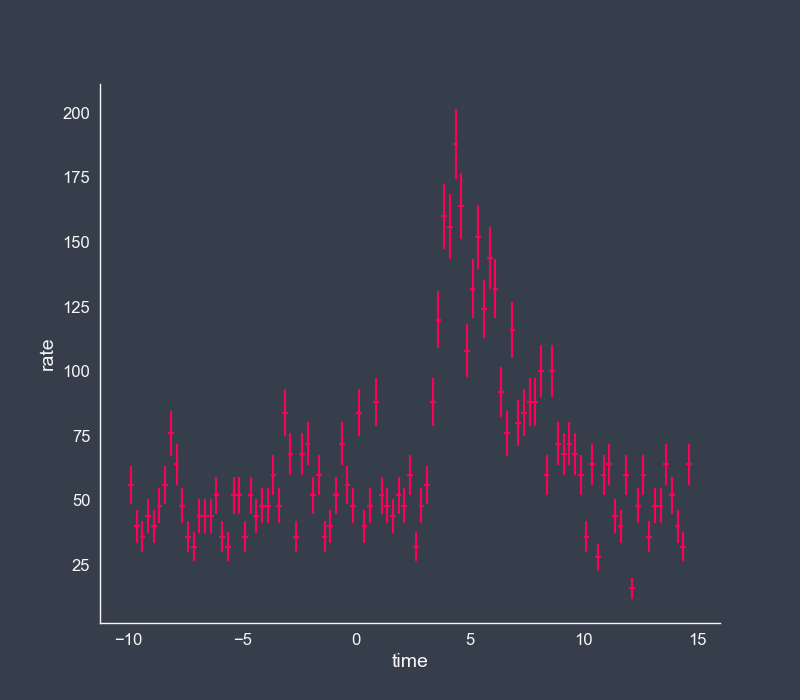

In [3]:
with plt.style.context('mike_dark'):

    uni = Universe.from_yaml('template_config.yaml')
    uni.explode_grb(tstart=-50,tstop=100)
    for det, lc in uni.light_curves.items():

        lc.display(-10,15,.25,color=red)



In [64]:
uni._time_differences

0.
2.96784228


In [40]:
lc = uni.light_curves['det1']
counts, times = lc.get_binned_light_curve(-10.4,21.4,.25)
mid = np.mean([times[:-1],times[1:]], axis=0)
width = times[1:] - times[:-1]




lc2 = uni.light_curves['det2']

counts2, times2 = lc2.get_binned_light_curve(-10,20,.25)
mid2 = np.mean([times2[:-1],times2[1:]], axis=0)
width2 = times2[1:] - times2[:-1]
k=50

N_model = 200

predict_time = np.linspace(-20,40,N_model)
omega=np.random.randn(k)

data = dict(N1=len(counts),
            time1=mid,
            counts1=counts.astype(int),
            exposure1=width,
            exposure2=width2,
            N2=len(counts2),
            time2=mid2,
            counts2=counts2.astype(int),
            k=k,
            bw=.3,
            omega=omega,
            N_model=N_model,
            predict_time=predict_time
           
           
           
           )

In [46]:
model = stan_utility.compile_model('rff.stan', model_name='rff')
#model = stan_utility.compile_model('gp_light_curve.stan', model_name='gplc')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL rff_762e1ced22c98e095f809503326b5b3f NOW.


In [ ]:
fit = model.sampling(warmup=1500,iter=2000,data=data, chains=4, seed=1234,
                     control = dict(max_treedepth=15, adapt_delta=.9)
                    

                    )

In [43]:
with plt.style.context('mike_dark'):
    fit.plot(['beta1','beta2',
              'dt',
              'log_amplitude1',
               'log_amplitude2'
             
             ]);

<IPython.core.display.Javascript object>

LinAlgError: singular matrix

<IPython.core.display.Javascript object>


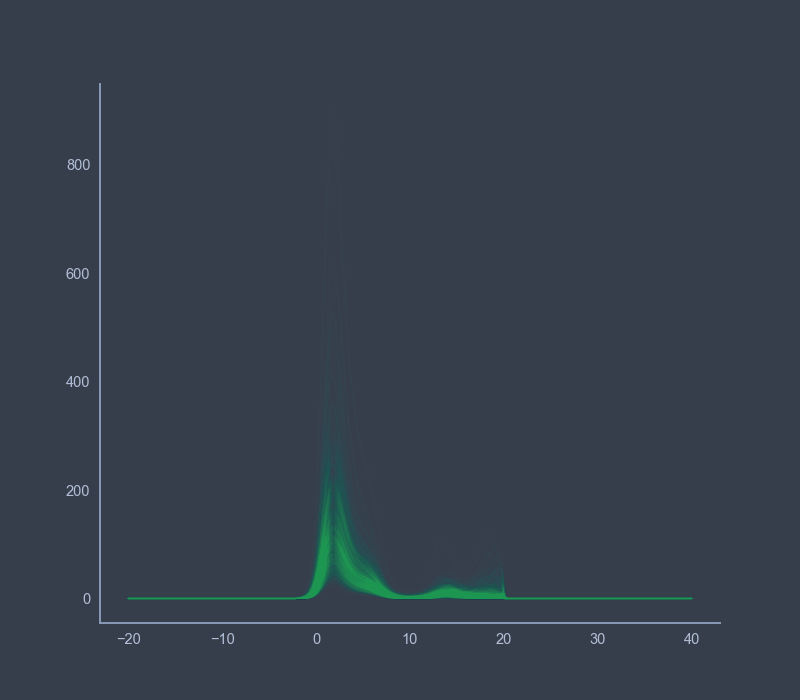

In [37]:
fig, ax = plt.subplots()

predict = fit.extract('predict')['predict']


for p in predict[::2]:

    ax.plot(predict_time,p, alpha=0.01, color=green )


<IPython.core.display.Javascript object>


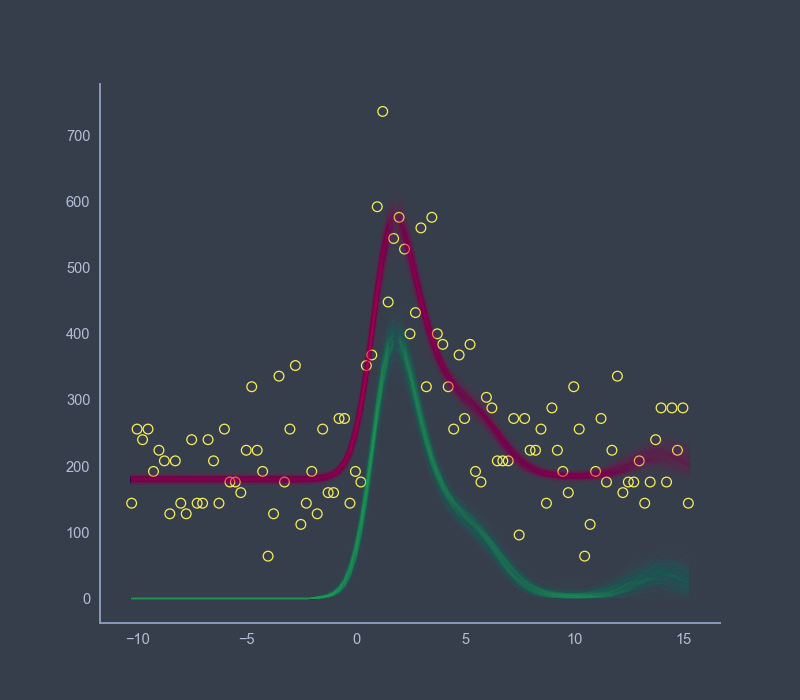

In [39]:
fig, ax = plt.subplots()

fhat = fit.extract("fhat1")["fhat1"]
bkg = fit.extract("bkg1")["bkg1"]

for y, b in zip(fhat[::10], bkg[::10]):

    ax.plot(mid, y, alpha=0.01, color=green)
    ax.plot(mid, (y + b), alpha=0.01, color=red)
#    ax.plot(mid,[b]*len(mid), alpha=0.01, color="k")


ax.scatter(mid, counts/width, edgecolor=yellow, facecolor="none", lw=0.9)

<IPython.core.display.Javascript object>


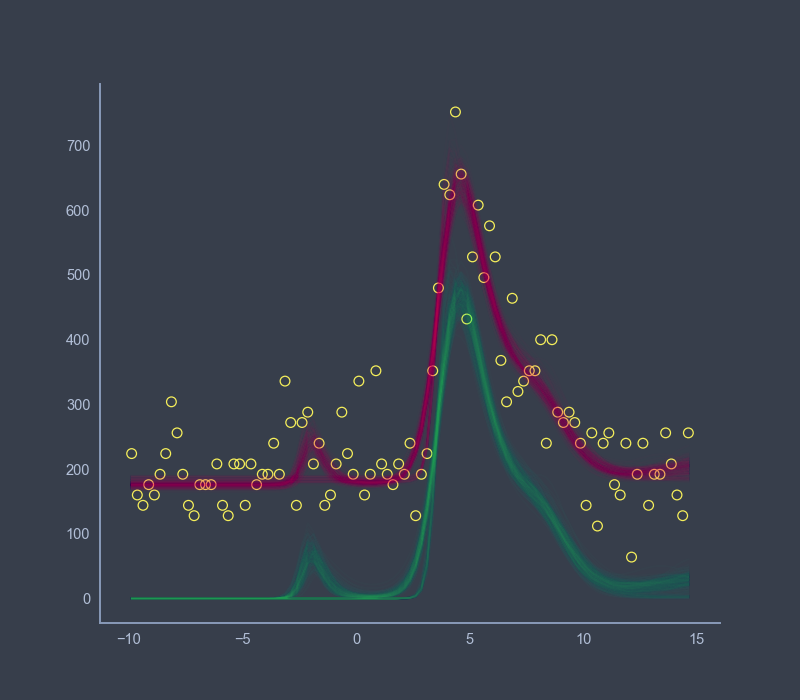

In [30]:
fig, ax = plt.subplots()

fhat = fit.extract('fhat2')['fhat2']
bkg = fit.extract('bkg2')['bkg2']

for y, b in zip(fhat[::10], bkg[::10]):

    ax.plot(mid2,y, alpha=0.01, color=green)
    ax.plot(mid2,y +b, alpha=0.01, color=red)
#    ax.plot(mid2,[b]*len(mid), alpha=0.01, color="k")


ax.scatter(mid2, counts2/width2, edgecolor=yellow, facecolor='none',lw=.9)

<IPython.core.display.Javascript object>


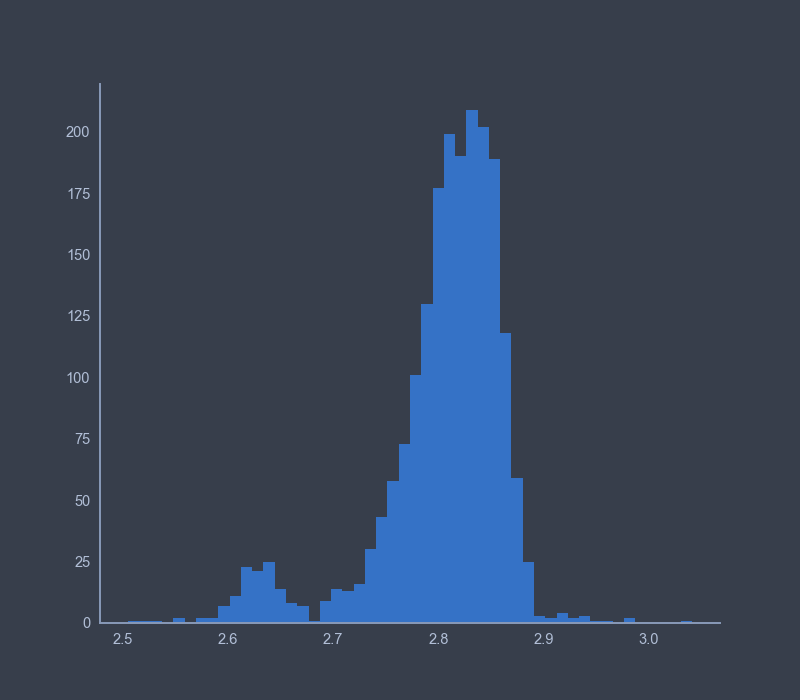

(array([  1.,   1.,   1.,   0.,   2.,   0.,   2.,   2.,   7.,  11.,  23.,
         21.,  25.,  14.,   8.,   7.,   1.,   9.,  14.,  13.,  16.,  30.,
         43.,  58.,  73., 101., 130., 177., 199., 190., 209., 202., 189.,
        118.,  59.,  25.,   3.,   2.,   4.,   2.,   3.,   1.,   1.,   0.,
          2.,   0.,   0.,   0.,   0.,   1.]),
 array([2.50486908, 2.51559617, 2.52632325, 2.53705033, 2.54777742,
        2.5585045 , 2.56923158, 2.57995866, 2.59068575, 2.60141283,
        2.61213991, 2.622867  , 2.63359408, 2.64432116, 2.65504824,
        2.66577533, 2.67650241, 2.68722949, 2.69795658, 2.70868366,
        2.71941074, 2.73013783, 2.74086491, 2.75159199, 2.76231907,
        2.77304616, 2.78377324, 2.79450032, 2.80522741, 2.81595449,
        2.82668157, 2.83740865, 2.84813574, 2.85886282, 2.8695899 ,
        2.88031699, 2.89104407, 2.90177115, 2.91249823, 2.92322532,
        2.9339524 , 2.94467948, 2.95540657, 2.96613365, 2.97686073,
        2.98758781, 2.9983149 , 3.00904198, 3.

In [22]:
fig, ax = plt.subplots()

dt = fit.extract('dt')['dt']


ax.hist(dt,bins=50)

<IPython.core.display.Javascript object>


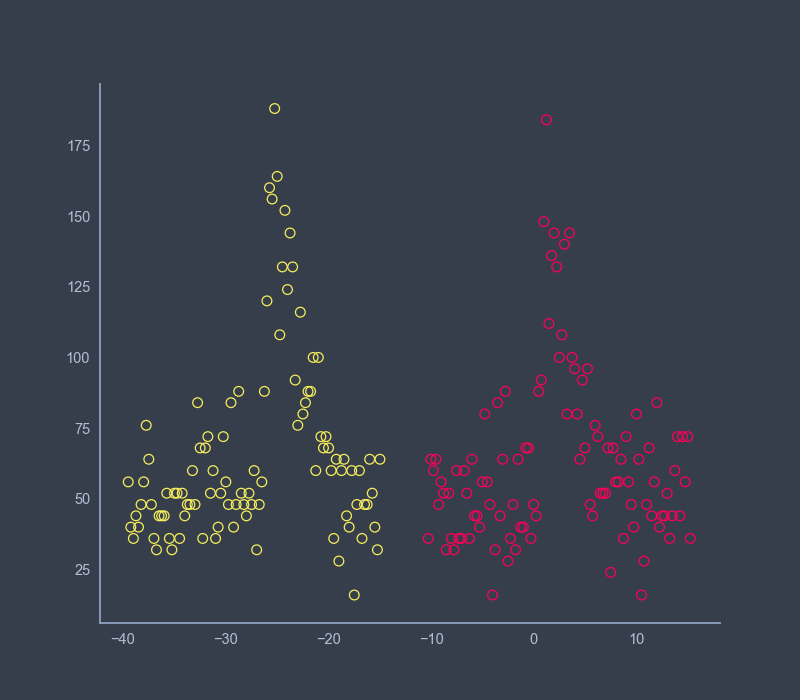

In [23]:
fig, ax = plt.subplots()

dt = 29.6


ax.scatter(mid2 -dt, counts2 , edgecolor=yellow, facecolor='none',lw=.9)
ax.scatter(mid, counts , edgecolor=red, facecolor='none',lw=.9)

<IPython.core.display.Javascript object>


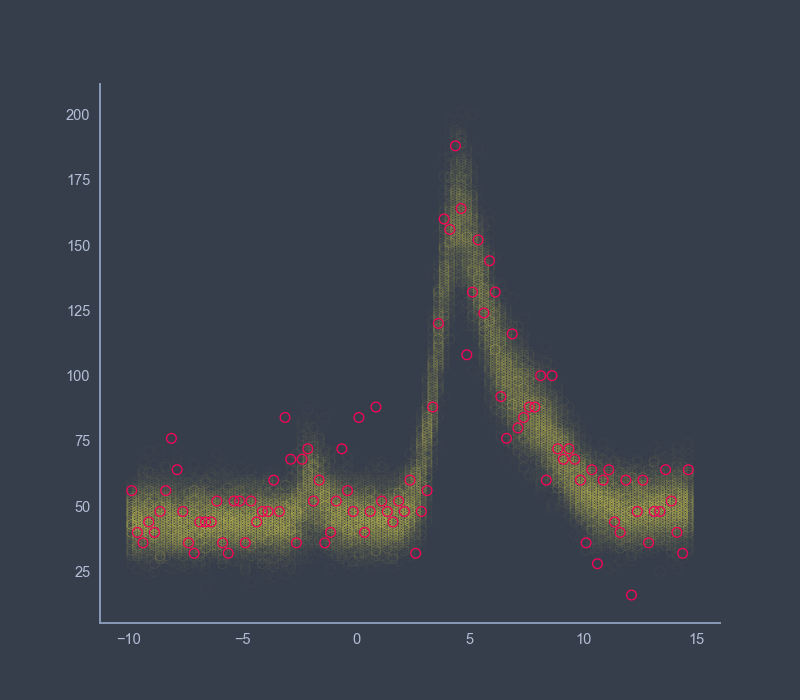

In [31]:
fig, ax = plt.subplots()

ppc2 = fit.extract('ppc2')['ppc2']


for p in ppc2[::10]:

    ax.scatter(mid2,p, alpha=0.025,  edgecolor=yellow, facecolor='none',lw=.9)
   
#    ax.plot(mid2,[b]*len(mid), alpha=0.01, color="k")


ax.scatter(mid2, counts2, edgecolor=red, facecolor='none',lw=.9)

<IPython.core.display.Javascript object>


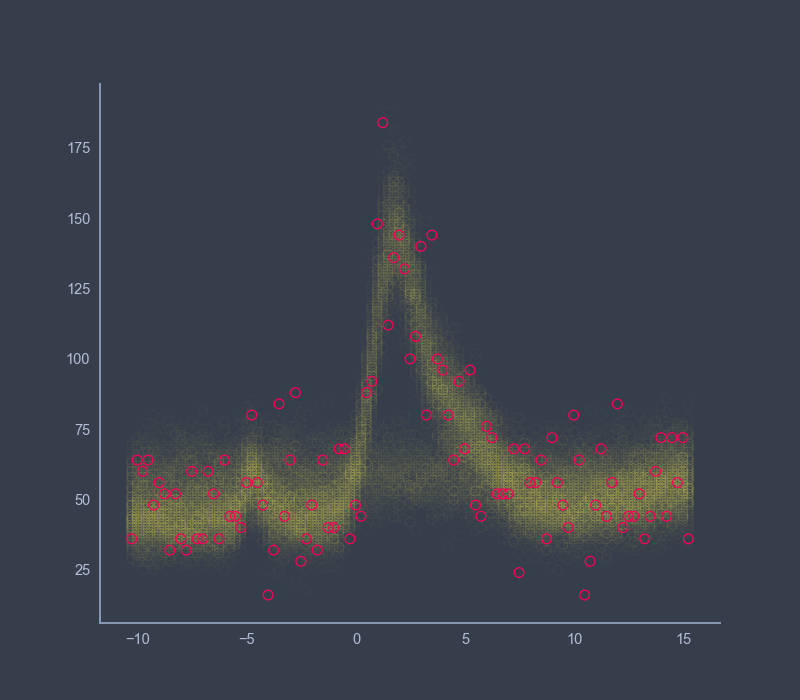

In [32]:
fig, ax = plt.subplots()

ppc1 = fit.extract('ppc1')['ppc1']


for p in ppc1[::10]:

    ax.scatter(mid,p, alpha=0.025,  edgecolor=yellow, facecolor='none',lw=.9)
   
#    ax.plot(mid2,[b]*len(mid), alpha=0.01, color="k")


ax.scatter(mid, counts, edgecolor=red, facecolor='none',lw=.9)